<a href="https://colab.research.google.com/github/alisonbans/ML4Science/blob/main/GHI_prediction_CS433.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Packages + Mount Drive

In [1]:
#importing packages
import numpy as np
import pandas as pd
import time
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import math
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import h5py
import sys
import datetime
from sklearn.linear_model import Ridge, ElasticNet, LinearRegression
from sklearn.model_selection import GridSearchCV, train_test_split
import tensorflow as tf
import keras
from tensorflow.keras.optimizers import  Adam
from tensorflow.keras.layers import Conv2D, LSTM, Flatten, BatchNormalization, TimeDistributed, Dense, \
MaxPooling2D, GlobalMaxPooling2D, Dropout, Reshape, concatenate, Flatten, Input, LocallyConnected2D
from tensorflow.keras.utils import Sequence
import cv2

from google.colab import files ### file.download() to download a file from colab instead of right clicking

In [2]:
#Mounting Drive
from google.colab import drive
# # # # This will prompt for authorization.
drive.mount("/content/drive")

## change path to where the folder of the images is
path = '/content/drive/MyDrive/CSS_433/data'
for file in os.listdir(path):
  print(file)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time.npy
new_irradiance.xlsx
labels.npy
ground_truth.npy
persistent_level.npy
meteo.xlsx
X.npy


In [ ]:
# Ensure the 'ML4Science' directory exists
!mkdir -p /content/drive/MyDrive/CSS_433/ML4Science/

# Navigate to the cloned directory
%cd /content/drive/MyDrive/CSS_433/ML4Science/

# Remove any existing files (if any)
!rm -rf *

# Copy the notebook into the ML4Science directory
!cp /content/drive/MyDrive/CSS_433/GHI_prediction_CS433.ipynb .

# Copy the "data" directory into the ML4Science directory
!cp -r /content/drive/MyDrive/CSS_433/data .

# Initialize a new Git repository
!git init

# Add changes
!git add .

# Commit changes
!git commit -m "Initial commit"

# Set the remote repository URL
!git remote add origin https://github.com/alisonbans/ML4Science.git

# Push changes to GitHub
!git push -u origin main



/content/drive/MyDrive/CSS_433/ML4Science
hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/drive/MyDrive/CSS_433/ML4Science/.git/


In [5]:
# Clone the GitHub repository
!git clone https://github.com/alisonbans/ML4Science.git

# Copy the notebook into the ML4Science directory
!cp /content/drive/MyDrive/CSS_433/GHI_prediction_CS433.ipynb /content/drive/MyDrive/CSS_433/ML4Science/

# Copy the "data" directory into the ML4Science directory
!cp -r /content/drive/MyDrive/CSS_433/data /content/drive/MyDrive/CSS_433/ML4Science/


Cloning into 'ML4Science'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (3/3), done.


In [7]:
%cd /content/drive/MyDrive/CSS_433/ML4Science/

# Add changes
!git add .

# Commit changes
!git commit -m "Initial commit"

# Push changes to GitHub
!git push origin main




[Errno 2] No such file or directory: '/content/drive/MyDrive/CSS_433/ML4Science/'
/content/drive/MyDrive/CSS_433/ML4Science
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
fatal: Unable to read current working directory: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
fatal: Unable to read current working directory: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
fatal: Unable to read current working directory: No such file or directory


# Importing Data

In [ ]:
### Loading the data
### loading the labels, basically the 2 hour GHI forecast
y = np.load(os.path.join(path, 'labels.npy'))
### loading the labels, basically the ture GHI values
ground_truth = np.load(os.path.join(path, 'ground_truth.npy'))
### loading the time at which the images were taken
### the time also corresposnds to the meteo data and the groun truth value
time = np.load(os.path.join(path, 'time.npy'),allow_pickle=True)

### Loading the X file, the file that contains the images
### this file has almost 11000 pair of images. each image has a size of 250x250x3
### so this X file has a shape of  10693,2,250,250,3
X = np.load(os.path.join(path, 'X.npy'),mmap_mode='c')
print(X.shape)

(10693, 2, 250, 250, 3)


In [ ]:
### if you want to resize the images to a certain size (here i chose (64,64)) but you can change it
dimensions = (64,64)
X_reduced = np.empty((X.shape[0],X.shape[1],dimensions[0],dimensions[1],3),dtype=int)

for i in [0,1]:
  for j in range(X.shape[0]):
    X_reduced[j,i] = cv2.resize(X[j,i,:,:,:], dimensions)

In [ ]:
X = X_reduced

# Splitting Train - test

In [ ]:
tf.random.set_seed(64)

In [ ]:
### Here i split the data into training and testing in a custom way
### we take a random sample of 400 (we can change it of course) images from the middle.
### that is we have a total of X images, I choose randomly a set of images not necessarly at the end and we train
### on everything else and we test on this selected batch (selected from the middle)
### maybe on google you might see a function called train_test_split
### we dont want to use it as this splits the data completely randomly which means we will loose
### the time series effect of the data s it shuffles the data then splits it

### how many images to test on
split_at_add = 400
### some random place to split the data at
### i would like you to choose one of these mainly 1270, 4000 and 7900
### feel free to choose other values for split_at to test different test sets
split_at = 1270
y_train = np.array(tuple(y[:len(X)][:split_at])+tuple(y[:len(X)][split_at+split_at_add:]))
y_test = y[:len(X)][split_at:split_at+split_at_add]

X_train = np.array(tuple(X[:len(X)][:split_at]) + tuple(X[:len(X)][split_at+split_at_add:]))
X_test = X[:len(X)][split_at:split_at+split_at_add]

print("Training: ", X_train.shape,y_train.shape)
print("Testing: ", X_test.shape,y_test.shape)

Training:  (10293, 2, 64, 64, 3) (10293,)
Testing:  (400, 2, 64, 64, 3) (400,)


# CNN-LSTM + BN

In [ ]:
### this part of the code is simply to help you load the data in parts so that you dont run out of memory so ignore it
### you can try to ignore this cell and dont run it and see if you dont run out of memory then its good
### otherwise use this cell. here we create train_data_generator which takes its data from X_Train and y_train in batches
### you can change batch size in line 21
class DataGenerator(Sequence):
    def __init__(self, x_set_sequence1, y_set, batch_size):
        self.x_sequence1 = x_set_sequence1
        self.y = y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x_sequence1) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x_sequence1 = self.x_sequence1[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x_sequence1, batch_y


### we you generate the dataset:
train_data_generator = DataGenerator(X_train, y_train, batch_size=64)

In [ ]:
tf.random.set_seed(64)
img_size = 64
channels = 3

### The network
## this layer takes as input 2 images of shape img_size, img_size, channels
### if you want for example to train on 1 image instead of 2, we change the 2 below to 1.
### then you also have to change the X_train in model.fit to X_train[:,0,:,:,:] or X_train[:,1,:,:,:] depending on which image you want to use
### the 0 or 1 determines which set of images you will be choosing
input_sequence1 = tf.keras.layers.Input(shape=(2,img_size, img_size, channels))

first_input = tf.keras.layers.TimeDistributed(Conv2D(16, kernel_size=3, activation='relu'))(input_sequence1)
first_input = tf.keras.layers.BatchNormalization()(first_input)
first_input = tf.keras.layers.TimeDistributed(Conv2D(16, kernel_size=3, activation='relu'))(first_input)
first_input = tf.keras.layers.BatchNormalization()(first_input)
first_input = tf.keras.layers.TimeDistributed(MaxPooling2D(pool_size = 2))(first_input)
first_input = tf.keras.layers.TimeDistributed(Dropout(0.3))(first_input)

first_input = tf.keras.layers.TimeDistributed(Conv2D(32, kernel_size=3, activation='relu'))(first_input)
first_input = tf.keras.layers.BatchNormalization()(first_input)
first_input = tf.keras.layers.TimeDistributed(Conv2D(32, kernel_size=3, activation='relu'))(first_input)
first_input = tf.keras.layers.BatchNormalization()(first_input)
first_input = tf.keras.layers.TimeDistributed(MaxPooling2D(pool_size = 2))(first_input)
first_input = tf.keras.layers.TimeDistributed(Dropout(0.1))(first_input)

flt = tf.keras.layers.TimeDistributed(Flatten())(first_input)
### This reshape is just to use lstm as it requires a 3d input
flt = tf.keras.layers.Reshape((1, -1))(flt)

lstm1 = tf.keras.layers.LSTM(128, activation='relu', return_sequences=True)(flt)
lstm1 = tf.keras.layers.LSTM(64, activation='relu', return_sequences=False)(lstm1)

dense1 = tf.keras.layers.Dense(64, activation='relu')(lstm1)
dense1 = tf.keras.layers.Dense(1, activation='relu')(dense1)

model = tf.keras.models.Model(inputs=[input_sequence1], outputs=dense1)

### basically to create the model
### technically the error can be changed to anything you want but  as we discussed
### mse makes the most sense unless you want to create your own error function
model.compile(optimizer="Adam", loss='mse')

### to train the model we give the training data. the number of epochs could be anything but we dont want to overtrain.
### batch_size can be changed but too big might crash your training as you might not have a lot of memory
### verbose is just something that you can ignore. its just something that the code would print for you
### callbacks is basically to help the code to stop and not overfit teh data. here we stop if the loss doesnt improve for 20 epochs
### as specified by the patience parameter. and i say min_delta=2 so if the error improves a bit but less than 2 then we consider as if
### the error didnt improve. finally we resotre the best weights to tell python to give us the best model in terms of error
### here i assume you will be using the full data to train. if you use the datagenerator function from the previous cell then use
### the command in line 54 and comment line 50 and 51
history = model.fit(np.asarray(X_train), np.asarray(y_train), shuffle=True, epochs=300,batch_size=64,verbose = 2,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20,restore_best_weights=True,min_delta=2)])


#history = model.fit(data_generator, shuffle=True, epochs=300,verbose = 2,
#                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20,restore_best_weights=True,min_delta=2)])



Epoch 1/300
161/161 - 24s - loss: 27050.6348 - 24s/epoch - 150ms/step
Epoch 2/300
161/161 - 6s - loss: 13074.8506 - 6s/epoch - 34ms/step
Epoch 3/300
161/161 - 6s - loss: 12185.1934 - 6s/epoch - 39ms/step
Epoch 4/300
161/161 - 5s - loss: 10852.7158 - 5s/epoch - 34ms/step
Epoch 5/300
161/161 - 6s - loss: 9996.7080 - 6s/epoch - 36ms/step
Epoch 6/300
161/161 - 6s - loss: 9716.6006 - 6s/epoch - 37ms/step
Epoch 7/300
161/161 - 5s - loss: 8917.8682 - 5s/epoch - 34ms/step
Epoch 8/300
161/161 - 6s - loss: 8509.7051 - 6s/epoch - 37ms/step
Epoch 9/300
161/161 - 6s - loss: 8255.8389 - 6s/epoch - 35ms/step
Epoch 10/300
161/161 - 6s - loss: 7713.9639 - 6s/epoch - 34ms/step
Epoch 11/300
161/161 - 6s - loss: 7307.8906 - 6s/epoch - 39ms/step
Epoch 12/300
161/161 - 6s - loss: 6713.3105 - 6s/epoch - 35ms/step
Epoch 13/300
161/161 - 6s - loss: 5954.4531 - 6s/epoch - 35ms/step
Epoch 14/300
161/161 - 6s - loss: 5799.4395 - 6s/epoch - 38ms/step
Epoch 15/300
161/161 - 5s - loss: 5341.5181 - 5s/epoch - 34ms/st

In [ ]:
### this is how the model predicts. we just say model.predict and we give the test data
predictions = model.predict([X_test])
### here we just adjust the data so that it is a vector to compute the root mean squared error with the true values (y_test)
predictions = np.array(predictions.tolist())
predictions = predictions.tolist()
print("RMSE: ",math.sqrt(mean_squared_error(y_test, predictions)),'\n')

13/13 [==============================] - 1s 19ms/step
RMSE:  62.04939452762485 



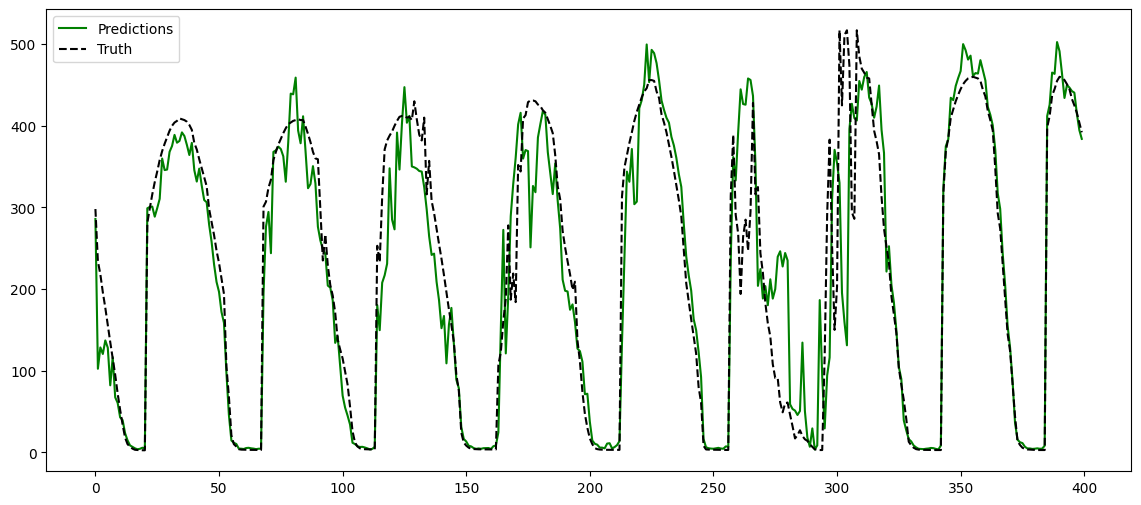

In [ ]:
#### a plot to visualize our predictions vs the true vlaues
plt.figure(figsize=(14,6))
plt.plot(predictions, 'g', label = "Predictions")
plt.plot(y_test, '--k',label = 'Truth')
plt.legend(loc = 'best')